# The Capstone Project - The Battle of Neighborhoods (Week 1)

# 1. Introduction/Business Problem 

If you want to **open a restaurant** in a big city like **Sao Paulo**, it could be a risky business - open it in the wrong neighborhood and you are ruined. In order to achieve success (besides making a great food), it is important to know this business first – so ask yourself:

    1.	What kind of restaurant are you going to open?
    2.	Who is your target?
    3.	Are there other restaurants in the area? How many? Which type?
    4.	Which type of venues exists in the neighborhood? 
    5.	Who lives in the Neighborhood?
    6.	Is the area safe?
    
You will need to address all the questions above if you want to find an answer to the problem, and have a successful restaurant in the city. 

**So the main question is: Where should I open a restaurant in Sao Paulo?**

Data Science can provide tools to dig into this problem, addressing some of the questions above and providing quantitative answers and insights that will help you to take right decision, and chose the best neighborhood to open a restaurant in Sao Paulo.

Most of the data needed to solve this problem can be retrieved using FourSquare:

    •	Venues list for each neighborhood;
    •	Venues categories list for each neighborhood;
    •	Venues prices classification for each venue (rated by customer);

This data will be processed, analyzed, and the end, it will produce insights that will tell more about each neighborhood in the city. Neighborhoods should be grouped by a machine leaning method (K-Means).

**The aim of this research** is to identify the **top 5 neigborhoods to open a restaurant in the City of Sao Paulo**. 


To start with,lets import the required libraries to run this notebook:

## Import libraries to run the notebook:

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


# 2. Data Section

To address the question "Where to open a restaurant on Sao Paulo, we will need to get two sets of data, to be stored in the following Pandas Dataframes:

**spdf**: These database contains the latitude and longitude of each neighborhood of Sao Paulo. It has the following columns:

    • Neighborhood: the name of the Neighborhood
    • Latitude....: the latitude of the Neighborhood
    • Longitude...: the longitude of the Neighborhood
    • Size........: This column will be used to define the relative "Size" of the Neighborhood. Size coud be, for exemplo, the number of expenvive restaurants in the area.

**sp_venues**: These database contains the Venues list for each neighborhood of Sao Paulo, with the following columns:

    • Neighborhood..........: the name of the Neighborhood
    • Neighborhood Latitude.: the latitude of the Neighborhood
    • Neighborhood Longitude: the longitude of the Neighborhood
    • Venue.................: Venue name
    • Venue Latitude........: Venue latitude
    • Venue Longitude.......: Venue longitude
    • Venue Category........: Venue Category 
    • Price.................: Client evaluation number from 1 (cheap) to 4 (expensive) rating the prices of the Venue.




## 2.1 Getting the Sao Paulo Neighborhoods:

The first step to get the data is getting the Latitude and Longitude of Sao Paulo neighborhoods. Since I could not find any  avaliable for download, neither I have de address of each central point of each neighborhood, had to build my own database. What I did:

    • Create an excel file named 'sp-neighborhoods.xls', with the following columns:
        • Neighborhood: the name of the Neighborhood
        • Latitude: the latitude of the Neighborhood
        • Longitude: the longitude of the Neighborhood
        • Size: This column will be used to define the relative "Size" of the Neighborhood. Size coud be, for exemplo, the number of expenvive restaurants in the area.
   
    • Using google maps, I got the latitude and longitude of the central point (visually estimated) of each neighborhood, and registered it in the excel file 'sp-neighborhoods.xls'
   
    • Column 'Size" was set at this stage to 10 (it will be modified later)

At the end, I build a database with 91 neighborhoods for the city of Sao Paulo. 

Let's read it and put into a Pandas Dataframe **spdf**:

### spdf dataframe

In [390]:
#Read into a pandas DataFrame, the Neighborhoods Latitude and Longitude for the city of Sao Paulo:
spdf=pd.read_excel('sp-neighborhoods.xls', index_col=0) 
spdf.head(10)

,Neighborhood,Latitude,Longitude,Size
index,,,,
0,Pinheiros (Paes Leme),-23.566997,-46.696343,10
1,Pinheiros (Fradique),-23.563412,-46.684643,10
2,Vila Madalena,-23.553547,-46.688649,10
3,Alto de Pinheiros,-23.553213,-46.708974,10
4,Boacava,-23.541327,-46.720548,10
5,Clinicas,-23.556694,-46.675425,10
6,Pacaembu,-23.546327,-46.668858,10
7,Jardim Europa,-23.574492,-46.681769,10
8,Itaim,-23.584443,-46.679146,10


As explained before, **size** is set a constant value for now. We will deal with this column later.

### Display São Paulo Neighborhoods:
the following function will display the Neighborhoods of Sao Paulo. The size (radius) of each Neighborhood displayed in the map:

In [391]:
def display_neighborhoods(df):    
    map_SP = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=12)
    # add markers to map
    for lat, lng, neighborhood, size in zip(df['Latitude'], df['Longitude'], df['Neighborhood'],df['Size']):
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=size/2,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_SP)
    return map_SP
    

In [392]:
display_neighborhoods(spdf)

... and just in case the Folium image above does not show in GitHub, I captured it in a JPG format below:

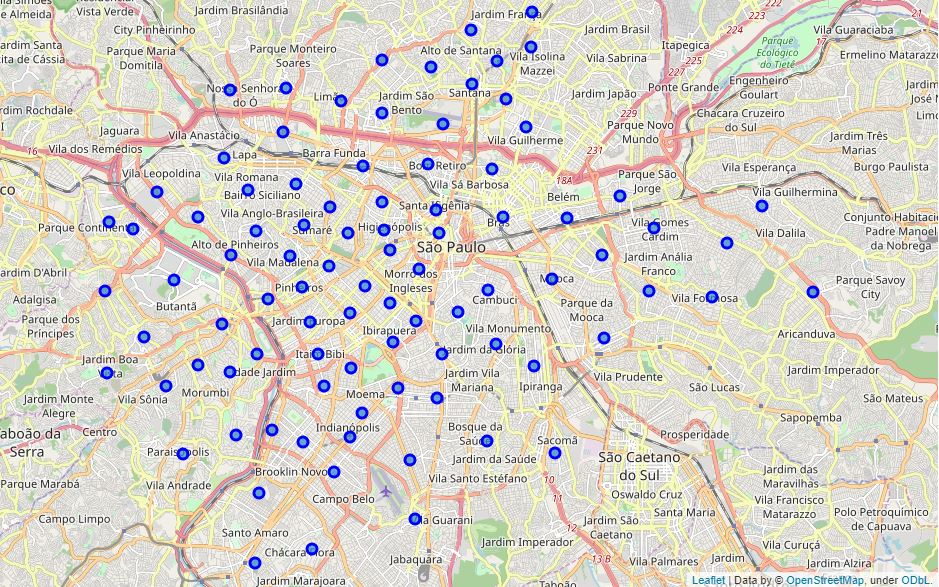

In [418]:
from IPython.display import Image
Image(filename='sp-neighborhoods.JPG') 

### Let's find the average distance between neighborhoods:
The funcion below calculate the distance between 2 points using Latitudes and Longitudes:

In [393]:
from math import cos, asin, sqrt, pi
def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a)) 

The loop below build a Distance Matrix. For each point (Neighborhood) is calculated the distance for every other point (Neighborhood) in spdf dataframe:

In [185]:
distance_between_neighborhoods = np.zeros([spdf.shape[0],spdf.shape[0]])
for i in range(0,spdf.shape[0]):
    for j in range(0,spdf.shape[0]):
        if i == j:
            distance_between_neighborhoods[i,j] = 9999999.  #Distance from 'itself' should not be considered 
        else:
            distance_between_neighborhoods[i,j] = distance (spdf.iloc[i,1],spdf.iloc[i,2],spdf.iloc[j,1],spdf.iloc[j,2]) 

The loop below get the minimum distance that each Neighborhood is from is closest neighbor:

In [186]:
smallest_distance_between_neighborhoods = []
for i in range(0,spdf.shape[0]):
    smallest_distance_between_neighborhoods.append(distance_between_neighborhoods[i,:].min())
df_smallest_distance_between_neighborhoods = pd.DataFrame(smallest_distance_between_neighborhoods)
df_smallest_distance_between_neighborhoods.columns=['Smallest distance between each Neighborhoods']
df_smallest_distance_between_neighborhoods.describe()

,Smallest distance between each Neighborhoods
count,91.000000
mean,1.459429
std,0.447308
min,0.741260
25%,1.137664
50%,1.387757
75%,1.720193
max,3.452532


#### From the above, we conclude that:
    * The Average distance between Neighborhoods is aproximately 1.46km
    * The 1st and 3rd Quartile are: 1.13km and 1.72 km 
    * The radius to pass to Foursquare URL request should be 1.46km / 2 = aprox. 750m

## 2.2 Getting the Venues Neighborhoods from Foursquare:
To build our database **sp_venues** described in item 2. of this report, I need to make a foursquare request, using the GET method and the EXPLORE endpoint to retrieve the data.

I will specify in the Foursquare request:

    • CLIENT_ID ...: Personal info for 'login'
    • CLIENT_SECRET: Personal info for 'login'
    • VERSION .....: Foursquare API version
    • price_filter : Price filter from 1 to 4
    • LIMIT .......: Maximum number of venues to return in the request
    • RADIUS ......: All venues found within this radius will be returned in the request 

In [1]:
CLIENT_ID = '###' # your Foursquare ID

CLIENT_SECRET = '###' # your Foursquare Secret

VERSION = '###' # Foursquare API version

LIMIT = 120 # limit of number of venues returned by Foursquare API

RADIUS = 750 # define radius

### Function to get venues from Forsquare:

In [397]:
def getNearbyVenues(names, latitudes, longitudes, price_filter):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, ' ( R=',RADIUS,', Price=',price_filter,')')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&price={}'.format(               
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT,
            price_filter)
            
        # make the GET request        
        results = requests.get(url).json()
        
        if str(results).find('groups') > 0:
            results=results["response"]['groups'][0]['items']        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Get venues from Foursquare:

Data will be retrieved in four parts, each part having the venues for a specific price filter:

    • sp_venues_p1: all venues having price = 1 (cheaper)
    • sp_venues_p2: all venues having price = 2 
    • sp_venues_p3: all venues having price = 3 
    • sp_venues_p4: all venues having price = 4 (expensive)
    
Then, all these 4 dataframes will be merged into a bigger one:

    • sp_venues: list of all venues in the city of Sao Paulo, having prices from 1 to 4

In [400]:
sp_venues_p1 = getNearbyVenues(names=spdf['Neighborhood'],latitudes=spdf['Latitude'],longitudes=spdf['Longitude'],price_filter=1)

Pinheiros (Paes Leme)  ( R= 750 , Price= 1 )
Pinheiros (Fradique)  ( R= 750 , Price= 1 )
Vila Madalena  ( R= 750 , Price= 1 )
Alto de Pinheiros  ( R= 750 , Price= 1 )
Boacava  ( R= 750 , Price= 1 )
Clinicas  ( R= 750 , Price= 1 )
Pacaembu  ( R= 750 , Price= 1 )
Jardim Europa  ( R= 750 , Price= 1 )
Itaim  ( R= 750 , Price= 1 )
Vila Olimpia  ( R= 750 , Price= 1 )
Brooklyn  ( R= 750 , Price= 1 )
Vila Funchal  ( R= 750 , Price= 1 )
Moema  ( R= 750 , Price= 1 )
Indianopolis  ( R= 750 , Price= 1 )
Campo Belo  ( R= 750 , Price= 1 )
Vila Nova Conceicao  ( R= 750 , Price= 1 )
Pq Ibirapuera  ( R= 750 , Price= 1 )
Cerqueira Cesar  ( R= 750 , Price= 1 )
Jardins  ( R= 750 , Price= 1 )
Pamplona  ( R= 750 , Price= 1 )
Consolacao  ( R= 750 , Price= 1 )
Higienopolis  ( R= 750 , Price= 1 )
Perdizes  ( R= 750 , Price= 1 )
Sumare  ( R= 750 , Price= 1 )
Vila Beatriz  ( R= 750 , Price= 1 )
Lapa  ( R= 750 , Price= 1 )
Agua Branca  ( R= 750 , Price= 1 )
Barra Funda  ( R= 750 , Price= 1 )
Bixiga  ( R= 750 , Pr

Ok, it worked! So let's get the next tree venues list for price tags 2, 3 and 4:

In [422]:
sp_venues_p2 = getNearbyVenues(names=spdf['Neighborhood'],latitudes=spdf['Latitude'],longitudes=spdf['Longitude'],price_filter=2)
sp_venues_p3 = getNearbyVenues(names=spdf['Neighborhood'],latitudes=spdf['Latitude'],longitudes=spdf['Longitude'],price_filter=3)
sp_venues_p4 = getNearbyVenues(names=spdf['Neighborhood'],latitudes=spdf['Latitude'],longitudes=spdf['Longitude'],price_filter=4)

... and add the price tag to each respective dataframe:

In [408]:
sp_venues_p1['Price']=1
sp_venues_p2['Price']=2
sp_venues_p3['Price']=3
sp_venues_p4['Price']=4

### Create dataframe sp_venues:

And now let's concatenate all 4 databases (each one for a specific price tag) into sp_venues:

In [409]:
sp_venues = pd.concat([sp_venues_p1,sp_venues_p2,sp_venues_p3,sp_venues_p4])

In [415]:
print('Total venues in sp_venues ..................: ',sp_venues.shape[0])
print('Total venues in sp_venues_pi (i from 1 to 4): ',sp_venues_p1.shape[0]+sp_venues_p2.shape[0]+sp_venues_p3.shape[0]+sp_venues_p4.shape[0])

Total venues in sp_venues ..................:  4647
Total venues in sp_venues_pi (i from 1 to 4):  4647


And **sp_venues** dataframe looks like this:

In [421]:
sp_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Price
0,Pinheiros (Paes Leme),-23.566997,-46.696343,Pitico,-23.566305,-46.696066,Beer Garden,1
1,Pinheiros (Paes Leme),-23.566997,-46.696343,Comedoria,-23.567765,-46.697848,Buffet,1
2,Pinheiros (Paes Leme),-23.566997,-46.696343,Bráz Elettrica,-23.566013,-46.695895,Pizza Place,1
3,Pinheiros (Paes Leme),-23.566997,-46.696343,St. Chico Padaria,-23.565137,-46.695565,Bakery,1
4,Pinheiros (Paes Leme),-23.566997,-46.696343,Um Coffee Co.,-23.568214,-46.698818,Coffee Shop,1
5,Pinheiros (Paes Leme),-23.566997,-46.696343,Remelexo Brasil,-23.567562,-46.698365,Nightclub,1
6,Pinheiros (Paes Leme),-23.566997,-46.696343,Neko's Burger,-23.567836,-46.699692,Burger Joint,1
7,Pinheiros (Paes Leme),-23.566997,-46.696343,Lupe Bar Y Taqueria,-23.563541,-46.693151,Taco Place,1
8,Pinheiros (Paes Leme),-23.566997,-46.696343,Joe King Coffee Shop,-23.563789,-46.695761,Coffee Shop,1
9,Pinheiros (Paes Leme),-23.566997,-46.696343,Buzina,-23.563703,-46.692851,Burger Joint,1


I am going to store each of these dafatrames into an excel file, so I can load these data easily next time:

In [411]:
sp_venues_p1.to_excel('sp_venues_p1.xls')
sp_venues_p2.to_excel('sp_venues_p2.xls')
sp_venues_p3.to_excel('sp_venues_p3.xls')
sp_venues_p4.to_excel('sp_venues_p4.xls')
sp_venues.to_excel('sp_venues.xls')

### How many venues for each neighborhood:

In [193]:
#Get Neighborhoods with number of Venues < 15:
n_venues = sp_venues[['Venue','Neighborhood']].groupby('Neighborhood').count().sort_values('Venue',ascending=False)

In [194]:
n_venues

,Venue
Neighborhood,
Itaim,169
Cerqueira Cesar,145
Pinheiros (Paes Leme),141
Pinheiros (Fradique),141
Consolacao,133
Pamplona,132
Ahangabau,132
Paraiso,115
Moema,113


### Concentration of restaurants for each Price tag in Sao Paulo:
First, lets create a dataframe for each price tag. These dataframe shoud have:

    • Neighborhood: NeighborhoodName    
    • Latitude and Longitude of the Neighborhood 
    • Price: Price Tag (1, 2, 3 or 4)
    • Size: Equals que total number of venues in the neighborhood for the Price Tag specified in Column "Price".
    
Lets prepare the dataframes:

In [426]:
#Group rows by Neighborhood, then sum values of Price, sorting by Price. Normalize total values for tags 1 to 3.
sp_prices_4 = sp_venues_p4[['Neighborhood','Price']].groupby('Neighborhood').sum().sort_values('Price',ascending=False)
sp_prices_3 = sp_venues_p3[['Neighborhood','Price']].groupby('Neighborhood').sum().sort_values('Price',ascending=False)//3
sp_prices_2 = sp_venues_p2[['Neighborhood','Price']].groupby('Neighborhood').sum().sort_values('Price',ascending=False)//2
sp_prices_1 = sp_venues_p1[['Neighborhood','Price']].groupby('Neighborhood').sum().sort_values('Price',ascending=False)
#Get Latitudes ans Longitudes from spdf dataframe:
sp_prices_1 = sp_prices_1.reset_index().merge(spdf, on = "Neighborhood", how = "inner")
sp_prices_2 = sp_prices_2.reset_index().merge(spdf, on = "Neighborhood", how = "inner")
sp_prices_3 = sp_prices_3.reset_index().merge(spdf, on = "Neighborhood", how = "inner")
sp_prices_4 = sp_prices_4.reset_index().merge(spdf, on = "Neighborhood", how = "inner")
#Update 'Size' with total values of 'Price' Column:
sp_prices_1['Size'] = sp_prices_1['Price']
sp_prices_2['Size'] = sp_prices_2['Price']
sp_prices_3['Size'] = sp_prices_3['Price']
sp_prices_4['Size'] = sp_prices_4['Price']

### Lets see the Top 10 Neighborhoods with Price Tag = 3: 

In [434]:
sp_prices_3.head(10)

,Neighborhood,Price,Latitude,Longitude,Size
0,Itaim,53,-23.584443,-46.679146,53
1,Cerqueira Cesar,49,-23.562896,-46.662927,49
2,Vila Olimpia,30,-23.594352,-46.677099,30
3,Ahangabau,22,-23.546509,-46.637784,22
4,Pamplona,22,-23.568407,-46.654559,22
5,Pinheiros (Paes Leme),22,-23.566997,-46.696343,22
6,Consolacao,21,-23.551686,-46.654571,21
7,Vila Nova Conceicao,20,-23.588958,-46.667895,20
8,Moema,20,-23.603159,-46.664217,20
9,Clinicas,18,-23.556694,-46.675425,18


### And now lets make a Follium Map from Neighborhoods with Price tag = 3 

    • Each circle in the folium map is a Neighborhood
    • The bigger the radius of the circle, greater the number of venues (with Price tag = 3) in that Neighborhood. 
    
So, ass we can see, **2 neighborhoods concentrate most number of expensive restaurants (with Price tag = 3) in Sao Paulo:**

In [428]:
display_neighborhoods(sp_prices_3)

... and just in case the Folium image above does not show in GitHub, I captured it in a JPG format below:

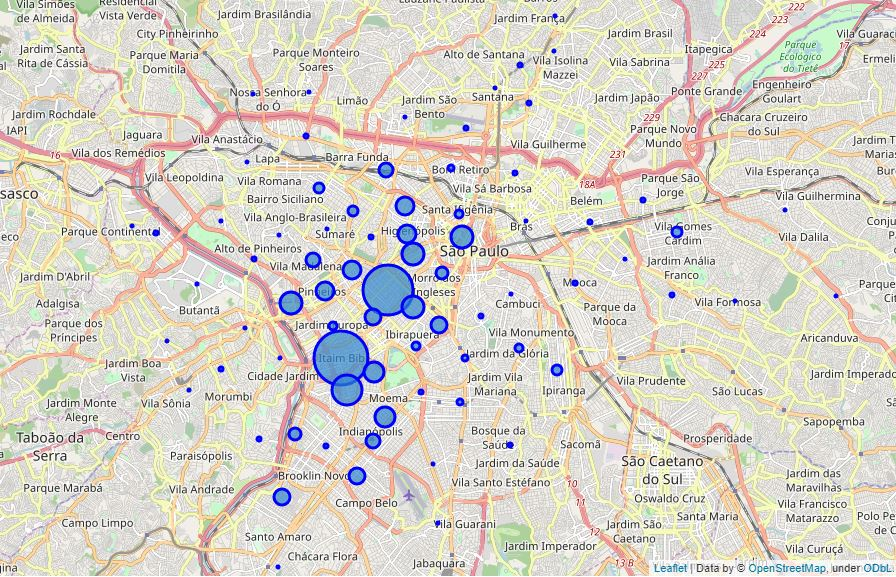

In [430]:
from IPython.display import Image
Image(filename='sp-total-venues-p3.JPG') 

... in the next steps (week 2) I will dig more into all avaliable data, analyse it and get useful insights that hopfully will  answer the main question here:

**Identify the top 5 neigborhoods to open a restaurant in the City of Sao Paulo**